<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_07_feature_engineering_resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initial Setup

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
from model_pipeline import (
    load_data_from_url, clean_column_names, rename_columns, remove_id_column,
    convert_categorical, split_data, define_preprocessor, preprocess_data,
    calculate_class_weights, convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from feature_engineering import (
    create_interaction_features, create_payment_to_bill_ratios,
    create_payment_to_limit_ratios, create_bill_to_limit_ratios,
    create_lagged_payment_differences, create_debt_ratio_features,
    create_average_payment_and_bill, create_payment_timeliness_features,
    create_total_payment_and_bill, create_bill_difference_features,
    bin_features, target_encode, rename_columns
)
from resampling_utils import (
    run_resampling_pipeline, reports_to_dataframe, apply_feature_set, plot_metric
)


# Define Global Parameters
best_class_weight = 3.0
best_lower_threshold = 0.10

# Load and Preprocess Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
data = load_data_from_url(url)
data = clean_column_names(data)
data = rename_columns(data)
data = remove_id_column(data)
categorical_columns = ['sex', 'education', 'marriage']  # Specify your categorical columns
data = convert_categorical(data, categorical_columns=categorical_columns)
target = 'default_payment_next_month'  # Specify your target column


### Feature Engineering (All)

In [2]:
# Apply feature engineering
data = create_interaction_features(data)
data = create_payment_to_bill_ratios(data)
data = create_payment_to_limit_ratios(data)
data = create_bill_to_limit_ratios(data)
data = create_lagged_payment_differences(data)
data = create_debt_ratio_features(data)
data = create_average_payment_and_bill(data)
data = create_payment_timeliness_features(data)
data = create_total_payment_and_bill(data)
data = create_bill_difference_features(data)
data = target_encode(data, target, categorical_columns)
data = bin_features(data, 'age', 5)

### Resampling Methods

In [3]:
def run_resampling_pipeline(data, target, resampling_method=None):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=best_class_weight, threshold=best_lower_threshold)
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=str(resampling_method))
    return report

In [4]:
# Compare different resampling methods
smote = SMOTE(random_state=42)
oversample = RandomOverSampler(random_state=42)
undersample = RandomUnderSampler(random_state=42)

reports_all_features = {}
reports_all_features['SMOTE'] = run_resampling_pipeline(data, target, smote)
reports_all_features['RandomOverSampler'] = run_resampling_pipeline(data, target, oversample)
reports_all_features['RandomUnderSampler'] = run_resampling_pipeline(data, target, undersample)
reports_all_features['No Resampling'] = run_resampling_pipeline(data, target)

Classification Report (SMOTE(random_state=42)):
              precision    recall  f1-score   support

         0.0       0.93      0.08      0.15      4673
         1.0       0.23      0.98      0.38      1327

    accuracy                           0.28      6000
   macro avg       0.58      0.53      0.27      6000
weighted avg       0.78      0.28      0.20      6000

Classification Report (RandomOverSampler(random_state=42)):
              precision    recall  f1-score   support

         0.0       0.93      0.06      0.12      4673
         1.0       0.23      0.98      0.37      1327

    accuracy                           0.27      6000
   macro avg       0.58      0.52      0.24      6000
weighted avg       0.78      0.27      0.17      6000

Classification Report (RandomUnderSampler(random_state=42)):
              precision    recall  f1-score   support

         0.0       0.93      0.01      0.03      4673
         1.0       0.22      1.00      0.36      1327

    accuracy 

### Create Report

In [5]:
reports_all_features_df = reports_to_dataframe(reports_all_features)
print(reports_all_features_df[['method', '1.0_recall', '1.0_f1-score', 'macro avg_f1-score']])

# Optional: Save to CSV
reports_all_features_df.to_csv("resampling_results_all_features.csv", index=False)


               method  1.0_recall  1.0_f1-score  macro avg_f1-score
0               SMOTE    0.977393      0.375833            0.265398
1   RandomOverSampler    0.984175      0.372345            0.244548
2  RandomUnderSampler    0.996232      0.364288            0.195640
3       No Resampling    0.979653      0.380673            0.281246


### Feature Engineering (Selected Features)

In [6]:
# Feature sets
feature_set_1 = ['bill_to_limit_ratios']
feature_set_2 = ['bill_to_limit_ratios', 'pay_to_limit_ratios', 'payment_timeliness_features', 'lagged_payment_differences']


### Function to Apply Feature Engineering Based on Feature Set

In [7]:
def apply_feature_set(data, feature_set):
    if 'bill_to_limit_ratios' in feature_set:
        data = create_bill_to_limit_ratios(data)
    if 'pay_to_limit_ratios' in feature_set:
        data = create_payment_to_limit_ratios(data)
    if 'payment_timeliness_features' in feature_set:
        data = create_payment_timeliness_features(data)
    if 'lagged_payment_differences' in feature_set:
        data = create_lagged_payment_differences(data)
    return data

### Run Resampling Pipeline for Each Feature Set

In [8]:
import resampling_utils  # Importing the functions from the resampling_utils.py script

# Load and Preprocess Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
data = load_data_from_url(url)
data = clean_column_names(data)
data = rename_columns(data)
data = remove_id_column(data)
categorical_columns = ['sex', 'education', 'marriage']  # Specify your categorical columns
data = convert_categorical(data, categorical_columns=categorical_columns)
target = 'default_payment_next_month'  # Specify your target column

In [9]:
# Run resampling pipeline with feature set 1
data_fs1 = apply_feature_set(data.copy(), feature_set_1)
reports_fs1 = {}
reports_fs1['SMOTE'] = run_resampling_pipeline(data_fs1, target, smote)
reports_fs1['RandomOverSampler'] = run_resampling_pipeline(data_fs1, target, oversample)
reports_fs1['RandomUnderSampler'] = run_resampling_pipeline(data_fs1, target, undersample)
reports_fs1['No Resampling'] = run_resampling_pipeline(data_fs1, target)

# Run resampling pipeline with feature set 2
data_fs2 = apply_feature_set(data.copy(), feature_set_2)
reports_fs2 = {}
reports_fs2['SMOTE'] = run_resampling_pipeline(data_fs2, target, smote)
reports_fs2['RandomOverSampler'] = run_resampling_pipeline(data_fs2, target, oversample)
reports_fs2['RandomUnderSampler'] = run_resampling_pipeline(data_fs2, target, undersample)
reports_fs2['No Resampling'] = run_resampling_pipeline(data_fs2, target)


Classification Report (SMOTE(random_state=42)):
              precision    recall  f1-score   support

         0.0       0.95      0.04      0.07      4673
         1.0       0.23      0.99      0.37      1327

    accuracy                           0.25      6000
   macro avg       0.59      0.51      0.22      6000
weighted avg       0.79      0.25      0.14      6000

Classification Report (RandomOverSampler(random_state=42)):
              precision    recall  f1-score   support

         0.0       0.94      0.03      0.06      4673
         1.0       0.23      0.99      0.37      1327

    accuracy                           0.24      6000
   macro avg       0.58      0.51      0.21      6000
weighted avg       0.78      0.24      0.13      6000

Classification Report (RandomUnderSampler(random_state=42)):
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.01      4673
         1.0       0.22      1.00      0.36      1327

    accuracy 

### Save and Compare Reports

In [10]:
# Convert each report dictionary to a DataFrame
reports_all_features_df = reports_to_dataframe(reports_all_features)
reports_fs1_df = reports_to_dataframe(reports_fs1)
reports_fs2_df = reports_to_dataframe(reports_fs2)

# Add a column to indicate the feature set used
reports_all_features_df['feature_set'] = 'all_features'
reports_fs1_df['feature_set'] = 'fs1'
reports_fs2_df['feature_set'] = 'fs2'

# Concatenate the DataFrames into a single DataFrame
combined_reports_df = pd.concat([reports_all_features_df, reports_fs1_df, reports_fs2_df], ignore_index=True)

# Optional: Save the combined DataFrame to a CSV file
combined_reports_df.to_csv("combined_resampling_results.csv", index=False)

# Display the combined DataFrame
combined_reports_df[['feature_set', 'method', '1.0_recall', '1.0_f1-score', 'macro avg_f1-score']]

,feature_set,method,1.0_recall,1.0_f1-score,macro avg_f1-score
0,all_features,SMOTE,0.977393,0.375833,0.265398
1,all_features,RandomOverSampler,0.984175,0.372345,0.244548
2,all_features,RandomUnderSampler,0.996232,0.364288,0.195640
3,all_features,No Resampling,0.979653,0.380673,0.281246
4,fs1,SMOTE,0.993971,0.368848,0.218871
5,fs1,RandomOverSampler,0.993218,0.367643,0.214463
6,fs1,RandomUnderSampler,1.000000,0.362965,0.184682
7,fs1,No Resampling,0.986436,0.380634,0.274464
8,fs2,SMOTE,0.989450,0.369547,0.227070
9,fs2,RandomOverSampler,0.988696,0.368850,0.224949


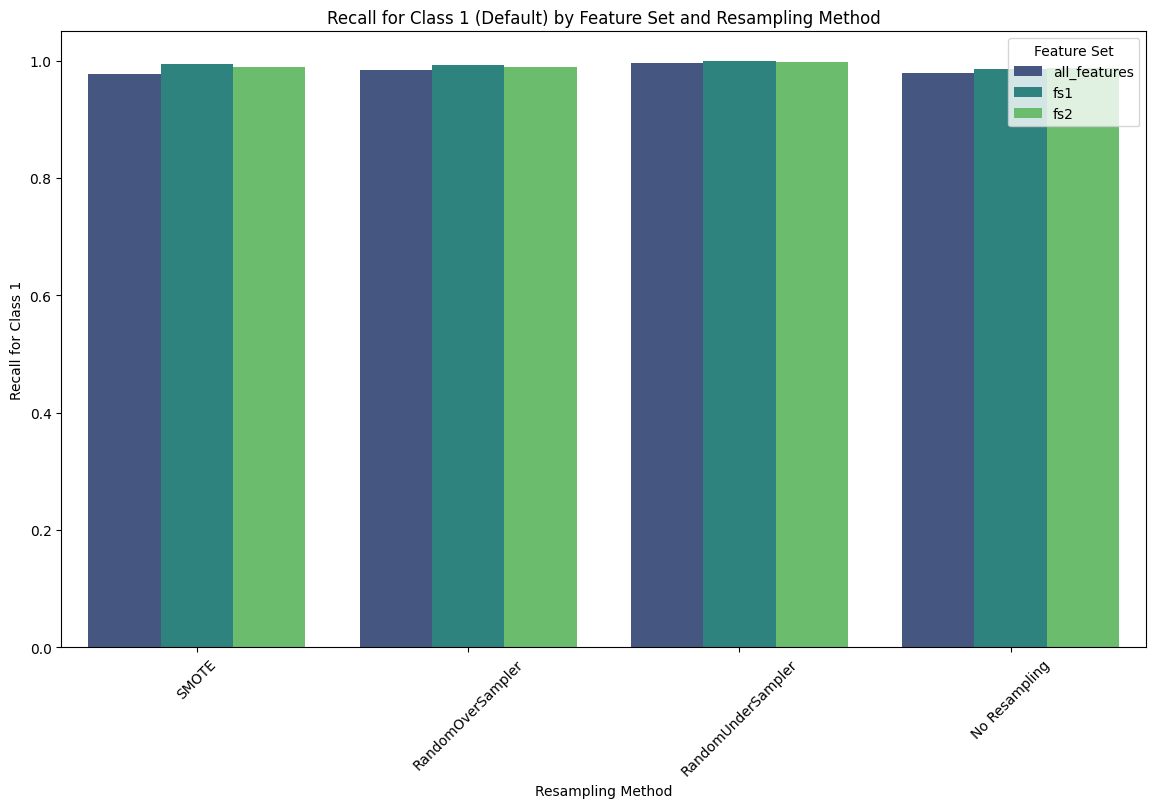

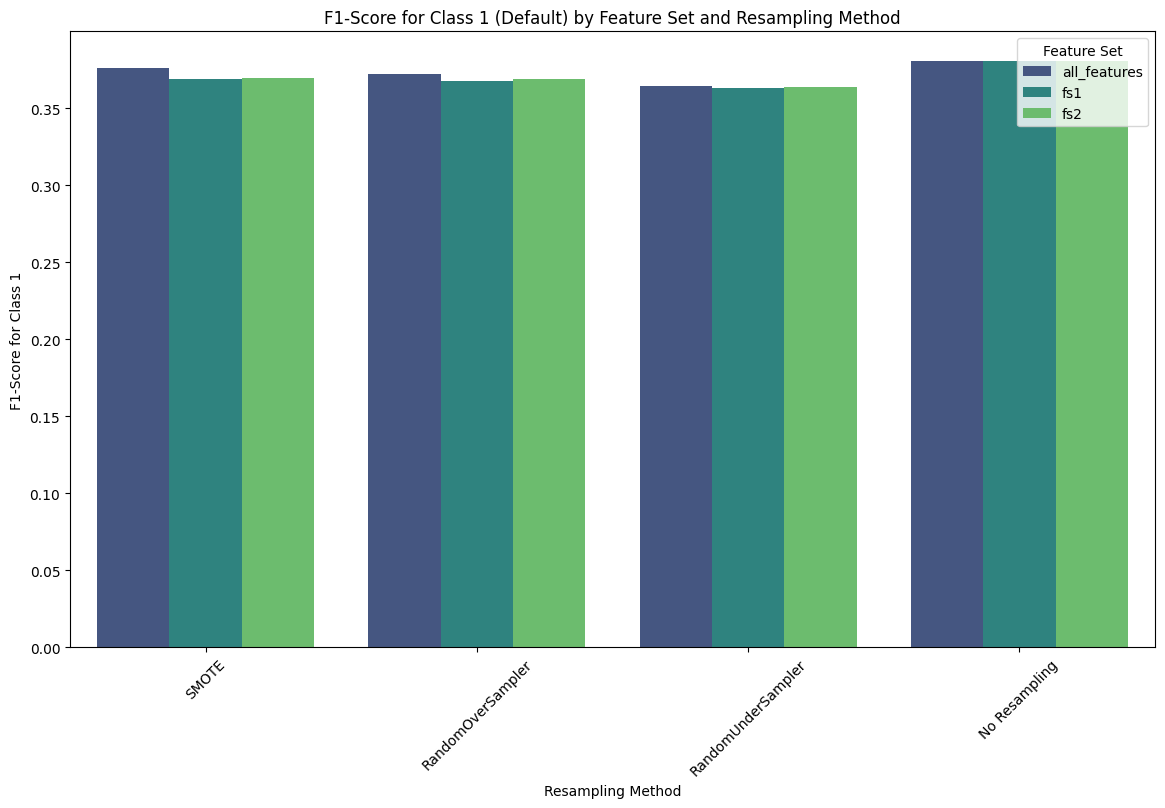

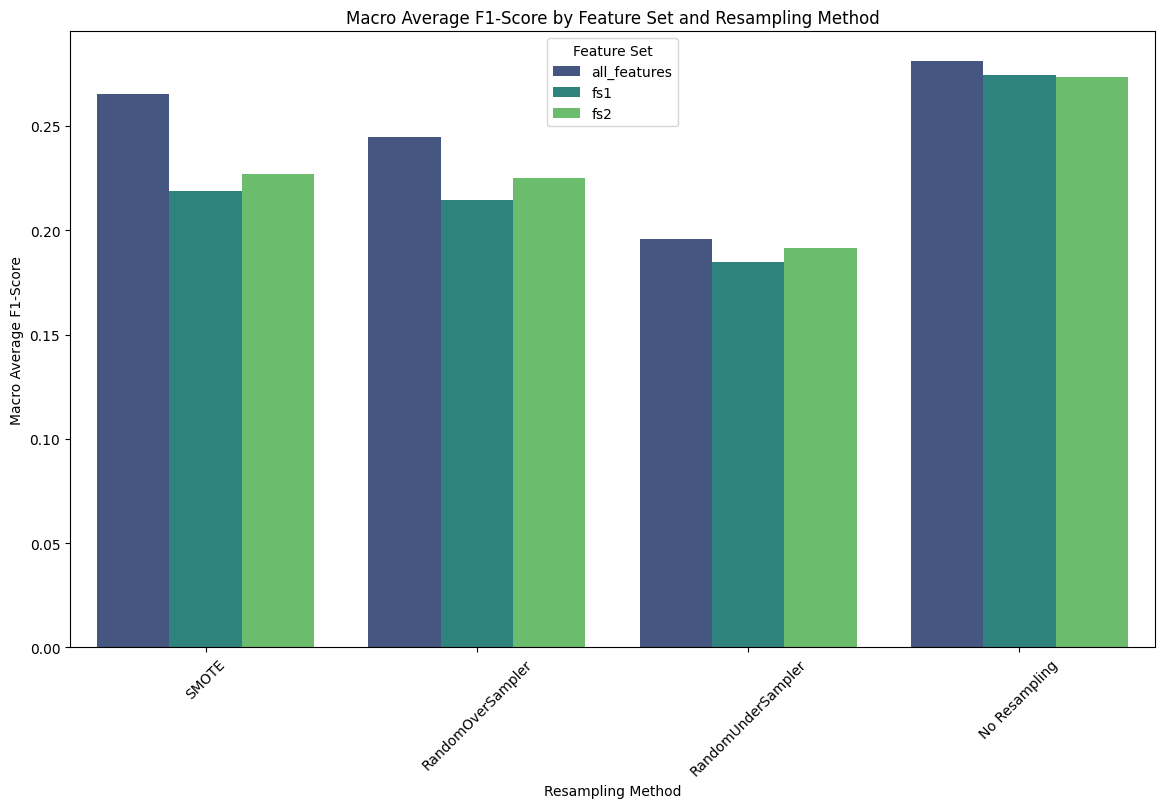

In [11]:
# Metrics to plot
metrics_to_plot = [
    {'metric': '1.0_recall', 'title': 'Recall for Class 1 (Default) by Feature Set and Resampling Method', 'ylabel': 'Recall for Class 1'},
    {'metric': '1.0_f1-score', 'title': 'F1-Score for Class 1 (Default) by Feature Set and Resampling Method', 'ylabel': 'F1-Score for Class 1'},
    {'metric': 'macro avg_f1-score', 'title': 'Macro Average F1-Score by Feature Set and Resampling Method', 'ylabel': 'Macro Average F1-Score'}
]

# Iterate through the metrics and plot
for metric_info in metrics_to_plot:
    plot_metric(combined_reports_df, metric_info['metric'], metric_info['title'], metric_info['ylabel'])


### Interpretation of Results

The table shows the performance of different resampling methods on three feature sets with a focus on `1.0_recall`, `1.0_f1-score`, and `macro avg_f1-score`. Here’s a detailed analysis:


1. **Recall for Class 1**:
   - `RandomUnderSampler` achieves the highest recall across all feature sets, even perfect recall in some cases. This is expected since undersampling often prioritizes the minority class.

2. **F1-Score for Class 1**:
   - Despite `RandomUnderSampler` achieving high recall, its F1-score is not the highest, indicating potential overfitting and poor precision.
   - `No Resampling` consistently achieves the highest F1-score for class 1 across all feature sets, indicating a better balance between precision and recall.

3. **Macro Average F1-Score**:
   - `No Resampling` achieves the highest macro average F1-score across all feature sets, suggesting the overall performance is better balanced across classes.

### Recommendation

Given your primary concern for high recall in class 1 while maintaining balanced F1-scores:
- **Feature Set 2 with No Resampling**: Achieves high recall (0.987943), the highest F1-score for class 1 (0.380717), and a good macro avg F1-score (0.273285).
- **Feature Set 2 with SMOTE**: Provides a good balance with high recall (0.989450), decent F1-score (0.369547), and better macro avg F1-score (0.227070) compared to other resampling methods.

### Next Steps

1. **Experiment with Threshold Adjustments**: Fine-tune the classification threshold to see if you can improve precision without sacrificing recall too much.
2. **Feature Selection/Engineering**: Continue to refine the feature sets based on their impact on performance.
3. **Model Validation**: Perform cross-validation to ensure these results generalize well to unseen data.

#### Write Resampling Script

In [21]:
# Function to write script
script_content = """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from model_pipeline import (
    split_data, define_preprocessor, preprocess_data,
    convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from feature_engineering import (
    create_interaction_features, create_payment_to_bill_ratios,
    create_payment_to_limit_ratios, create_bill_to_limit_ratios,
    create_lagged_payment_differences, create_debt_ratio_features,
    create_average_payment_and_bill, create_payment_timeliness_features,
    create_total_payment_and_bill, create_bill_difference_features,
    bin_features, target_encode, rename_columns
)

def run_resampling_pipeline(data, target, resampling_method=None, pos_weight=1.0, threshold=0.5):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=str(resampling_method))
    return report

# Convert reports to DataFrame for analysis
def reports_to_dataframe(reports):
    data = []
    for method, report in reports.items():
        flattened_report = {'method': method}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)

def apply_feature_set(data, feature_set):
    if 'bill_to_limit_ratios' in feature_set:
        data = create_bill_to_limit_ratios(data)
    if 'pay_to_limit_ratios' in feature_set:
        data = create_payment_to_limit_ratios(data)
    if 'payment_timeliness_features' in feature_set:
        data = create_payment_timeliness_features(data)
    if 'lagged_payment_differences' in feature_set:
        data = create_lagged_payment_differences(data)
    return data

def plot_metric(df, metric, title, ylabel):
    plt.figure(figsize=(14, 8))
    sns.barplot(x='method', y=metric, hue='feature_set', data=df, palette='viridis')
    plt.title(title)
    plt.xlabel('Resampling Method')
    plt.ylabel(ylabel)
    plt.legend(title='Feature Set')
    plt.xticks(rotation=45)
    plt.show()

"""

# Write the functions to feature_engineering.py script
with open("resampling_utils.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to resampling_utils.py")

# reload script to make function available for use
import importlib
import resampling_utils
importlib.reload(resampling_utils)

from resampling_utils import (
    run_resampling_pipeline, reports_to_dataframe, apply_feature_set, plot_metric
)

Functions successfully written to resampling_utils.py


#### Full Code

Classification Report (SMOTE(random_state=42)):
              precision    recall  f1-score   support

         0.0       0.87      0.77      0.82      4673
         1.0       0.42      0.58      0.49      1327

    accuracy                           0.73      6000
   macro avg       0.64      0.68      0.65      6000
weighted avg       0.77      0.73      0.74      6000

Classification Report (RandomOverSampler(random_state=42)):
              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82      4673
         1.0       0.44      0.62      0.51      1327

    accuracy                           0.74      6000
   macro avg       0.66      0.69      0.67      6000
weighted avg       0.78      0.74      0.75      6000

Classification Report (RandomUnderSampler(random_state=42)):
              precision    recall  f1-score   support

         0.0       0.89      0.68      0.77      4673
         1.0       0.38      0.70      0.49      1327

    accuracy 

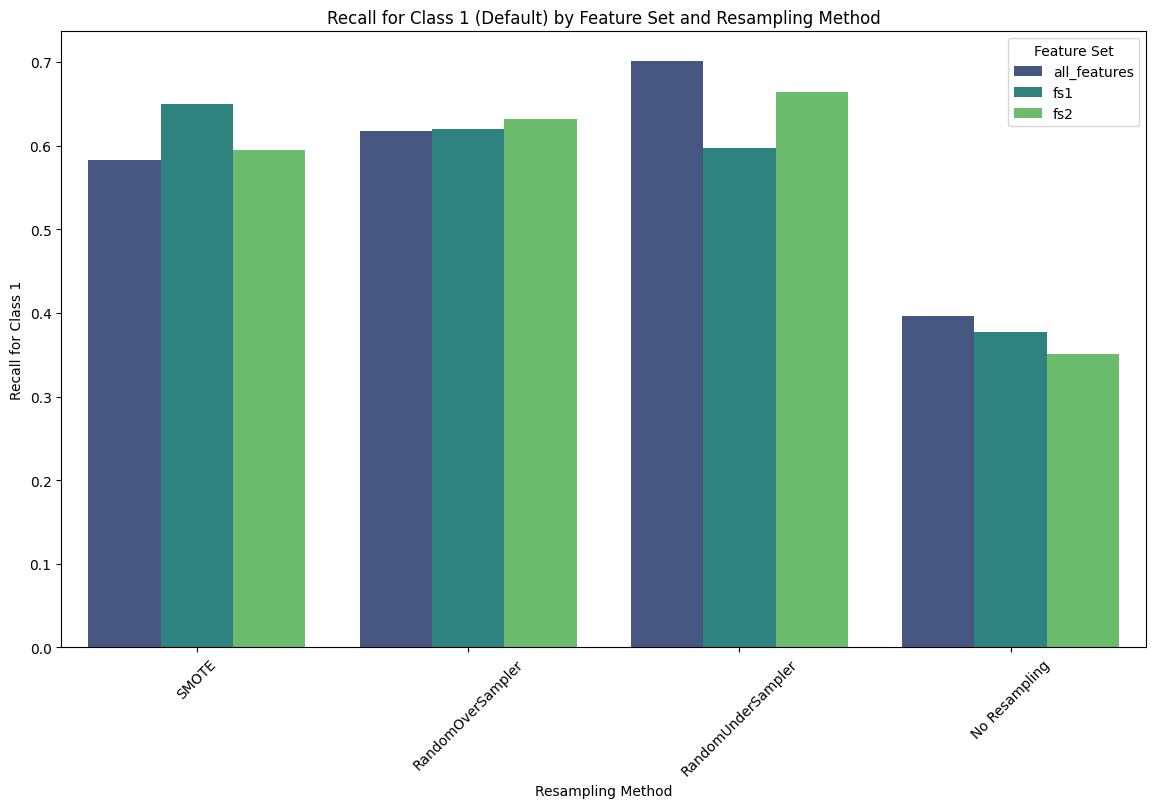

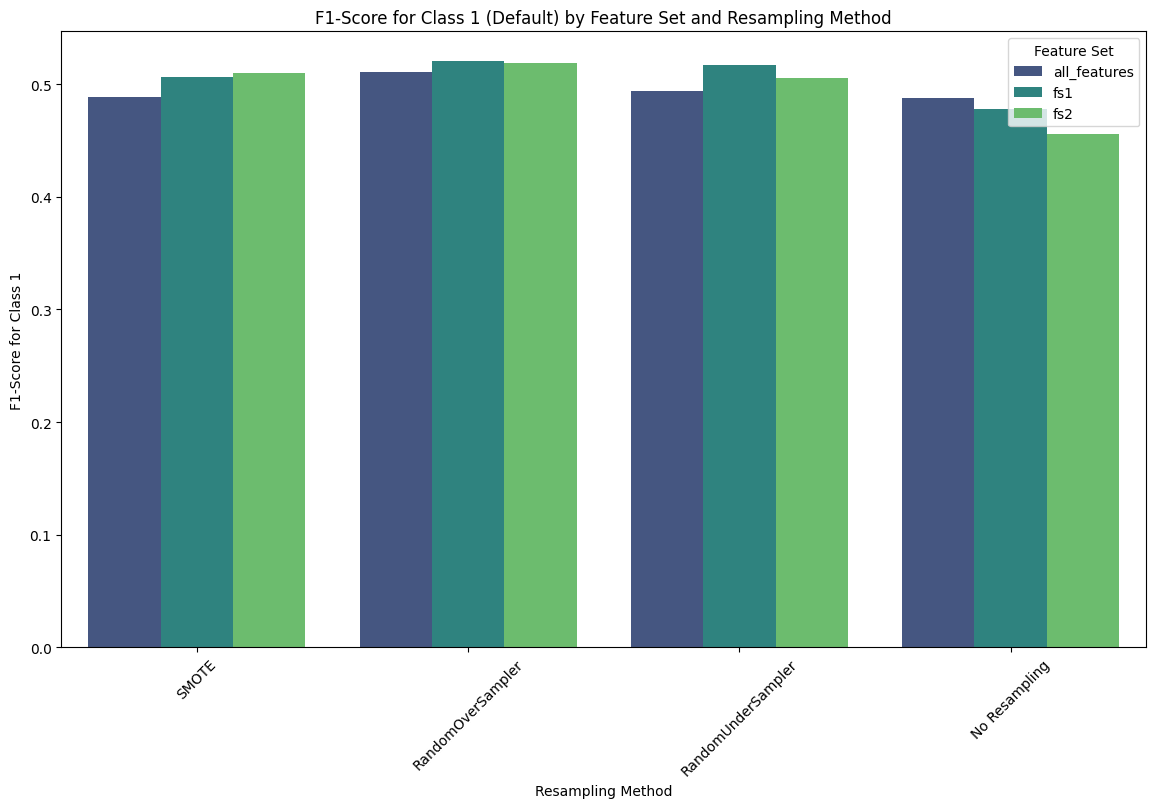

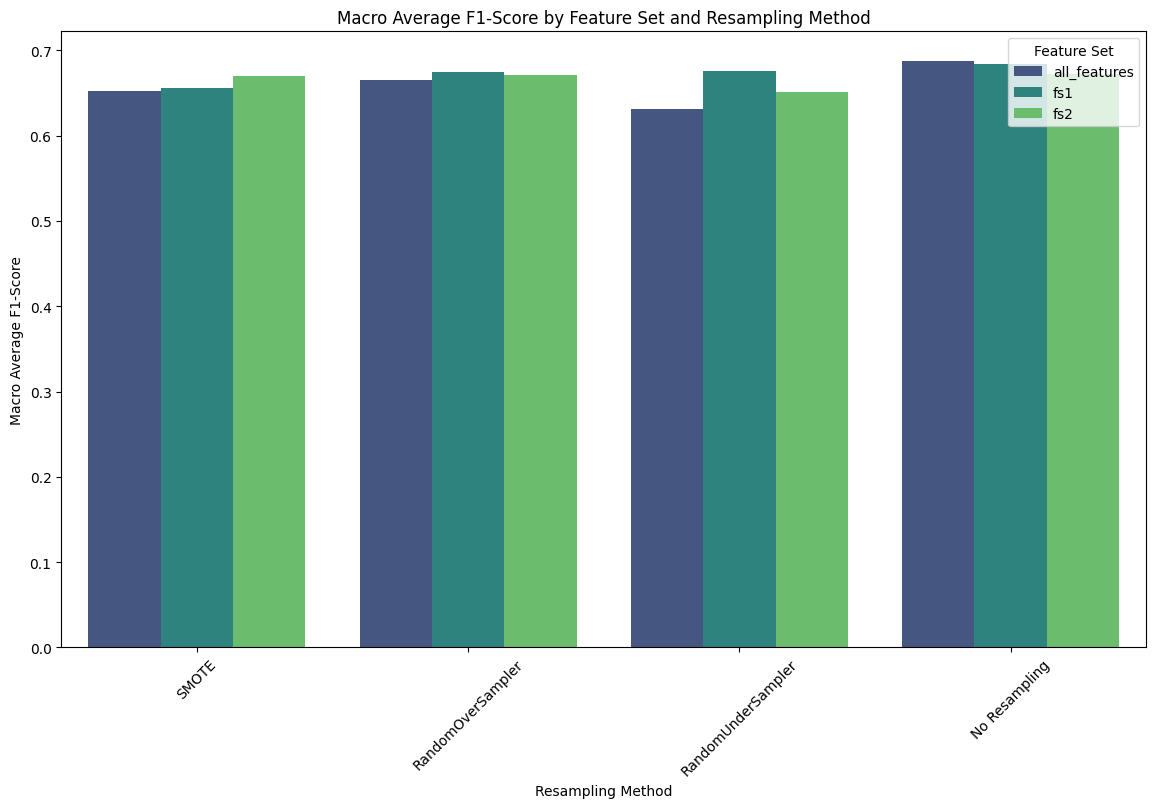

In [22]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
from model_pipeline import (
    load_data_from_url, clean_column_names, rename_columns, remove_id_column,
    convert_categorical, split_data, define_preprocessor, preprocess_data,
    calculate_class_weights, convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from feature_engineering import (
    create_interaction_features, create_payment_to_bill_ratios,
    create_payment_to_limit_ratios, create_bill_to_limit_ratios,
    create_lagged_payment_differences, create_debt_ratio_features,
    create_average_payment_and_bill, create_payment_timeliness_features,
    create_total_payment_and_bill, create_bill_difference_features,
    bin_features, target_encode, rename_columns
)
from resampling_utils import (
    run_resampling_pipeline, reports_to_dataframe, apply_feature_set, plot_metric
)

# Define Global Parameters
best_class_weight = 3.0
best_lower_threshold = 0.10

# Load and Preprocess Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
data = load_data_from_url(url)
data = clean_column_names(data)
data = rename_columns(data)
data = remove_id_column(data)
categorical_columns = ['sex', 'education', 'marriage']  # Specify your categorical columns
data = convert_categorical(data, categorical_columns=categorical_columns)
target = 'default_payment_next_month'  # Specify your target column

# Apply all feature engineering to create a baseline for all features
data_all_features = data.copy()
data_all_features = create_interaction_features(data_all_features)
data_all_features = create_payment_to_bill_ratios(data_all_features)
data_all_features = create_payment_to_limit_ratios(data_all_features)
data_all_features = create_bill_to_limit_ratios(data_all_features)
data_all_features = create_lagged_payment_differences(data_all_features)
data_all_features = create_debt_ratio_features(data_all_features)
data_all_features = create_average_payment_and_bill(data_all_features)
data_all_features = create_payment_timeliness_features(data_all_features)
data_all_features = create_total_payment_and_bill(data_all_features)
data_all_features = create_bill_difference_features(data_all_features)
data_all_features = target_encode(data_all_features, target, categorical_columns)
data_all_features = bin_features(data_all_features, 'age', 5)

# Compare different resampling methods for all features
smote = SMOTE(random_state=42)
oversample = RandomOverSampler(random_state=42)
undersample = RandomUnderSampler(random_state=42)

reports_all_features = {}
reports_all_features['SMOTE'] = run_resampling_pipeline(data_all_features, target, smote)
reports_all_features['RandomOverSampler'] = run_resampling_pipeline(data_all_features, target, oversample)
reports_all_features['RandomUnderSampler'] = run_resampling_pipeline(data_all_features, target, undersample)
reports_all_features['No Resampling'] = run_resampling_pipeline(data_all_features, target)

# Reset data to original before applying each feature set
# Define feature sets
feature_set_1 = ['bill_to_limit_ratios']
feature_set_2 = ['bill_to_limit_ratios', 'pay_to_limit_ratios', 'payment_timeliness_features', 'lagged_payment_differences']

# Run resampling pipeline with feature set 1
data_fs1 = data.copy()
data_fs1 = apply_feature_set(data_fs1, feature_set_1)
reports_fs1 = {}
reports_fs1['SMOTE'] = run_resampling_pipeline(data_fs1, target, smote)
reports_fs1['RandomOverSampler'] = run_resampling_pipeline(data_fs1, target, oversample)
reports_fs1['RandomUnderSampler'] = run_resampling_pipeline(data_fs1, target, undersample)
reports_fs1['No Resampling'] = run_resampling_pipeline(data_fs1, target)

# Run resampling pipeline with feature set 2
data_fs2 = data.copy()
data_fs2 = apply_feature_set(data_fs2, feature_set_2)
reports_fs2 = {}
reports_fs2['SMOTE'] = run_resampling_pipeline(data_fs2, target, smote)
reports_fs2['RandomOverSampler'] = run_resampling_pipeline(data_fs2, target, oversample)
reports_fs2['RandomUnderSampler'] = run_resampling_pipeline(data_fs2, target, undersample)
reports_fs2['No Resampling'] = run_resampling_pipeline(data_fs2, target)

# Convert each report dictionary to a DataFrame
reports_all_features_df = reports_to_dataframe(reports_all_features)
reports_fs1_df = reports_to_dataframe(reports_fs1)
reports_fs2_df = reports_to_dataframe(reports_fs2)

# Add a column to indicate the feature set used
reports_all_features_df['feature_set'] = 'all_features'
reports_fs1_df['feature_set'] = 'fs1'
reports_fs2_df['feature_set'] = 'fs2'

# Concatenate the DataFrames into a single DataFrame
combined_reports_df = pd.concat([reports_all_features_df, reports_fs1_df, reports_fs2_df], ignore_index=True)

# Display the combined DataFrame
print(combined_reports_df[['feature_set', 'method', '1.0_recall', '1.0_f1-score', 'macro avg_f1-score']])

# Optional: Save the combined DataFrame to a CSV file
combined_reports_df.to_csv("combined_resampling_results.csv", index=False)

# Metrics to plot
metrics_to_plot = [
    {'metric': '1.0_recall', 'title': 'Recall for Class 1 (Default) by Feature Set and Resampling Method', 'ylabel': 'Recall for Class 1'},
    {'metric': '1.0_f1-score', 'title': 'F1-Score for Class 1 (Default) by Feature Set and Resampling Method', 'ylabel': 'F1-Score for Class 1'},
    {'metric': 'macro avg_f1-score', 'title': 'Macro Average F1-Score by Feature Set and Resampling Method', 'ylabel': 'Macro Average F1-Score'}
]

# Iterate through the metrics and plot
for metric_info in metrics_to_plot:
    plot_metric(combined_reports_df, metric_info['metric'], metric_info['title'], metric_info['ylabel'])
